In [1]:
import sys
import pickle
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from skylens import *
# from fisher import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [5]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [6]:
import skylens
reload(skylens)
from skylens import *
from wigner_transform import *

In [7]:
import skylens.hankel_transform
from astropy.io import fits
# reload(hankel_transform)
from skylens.hankel_transform import *


In [8]:
def readclxipm(filename):
    nz_bins=4
    na=20
    nz=np.int(nz_bins*(nz_bins+1.)/2.)
    print(nz)
    n_theta=ndesa=20
    tp_fits = fits.open(filename)[1].data #fitsio.FITS(filename)
    #xip = tp_fits['xip']
    #theta = xip['ang'][:ndesa]
    #thc = np.delete(theta,range(ndesa-na))

    ccl = tp_fits#[1]
    ccl_xip=ccl[:2*ndesa*nz,:2*ndesa*nz] #factor of 2 for xi_-
    #print ccl_xip[399,390:399]
    cov=np.zeros((2*nz*na,2*nz*na))
    for z1 in range(2*nz):
        for a1 in range(na):
            i1 = a1+z1*na
        ## The index in the original matrix is skewed because that matrix contains
        ## angles that have been cut. So 
            i1ccl = (a1+ndesa-na) + z1*ndesa
            for z2 in range(2*nz):
                for a2 in range(na):
                    i2 = a2 + z2*na
                ## The index in the original matrix is skewed because that matrix contains
                ## angles that have been cut. So 
                    i2ccl = (a2+ndesa-na) + z2*ndesa
                    cov[i1,i2]=ccl_xip[i1ccl,i2ccl]
    return cov

In [9]:
fname='../data/2pt_NG_mcal_1110.fits'
DES_dat=fits.open(fname)

In [10]:
DES_dat[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =                  200 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
2PTDATA =                    T                                                  
EXTNAME = 'xip     '                                                            
QUANT1  = 'G+R     '                                                            
QUANT2  = 'G+R     '                                                            
KERNEL_1= 'nz_source'       

In [11]:
cov_des=readclxipm(filename=fname)
# corr_des=cc.corr_matrix(cov_des)

10


In [12]:
pz=Table.read(fname,format='fits',hdu=6)

In [13]:
f_sky=1321./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

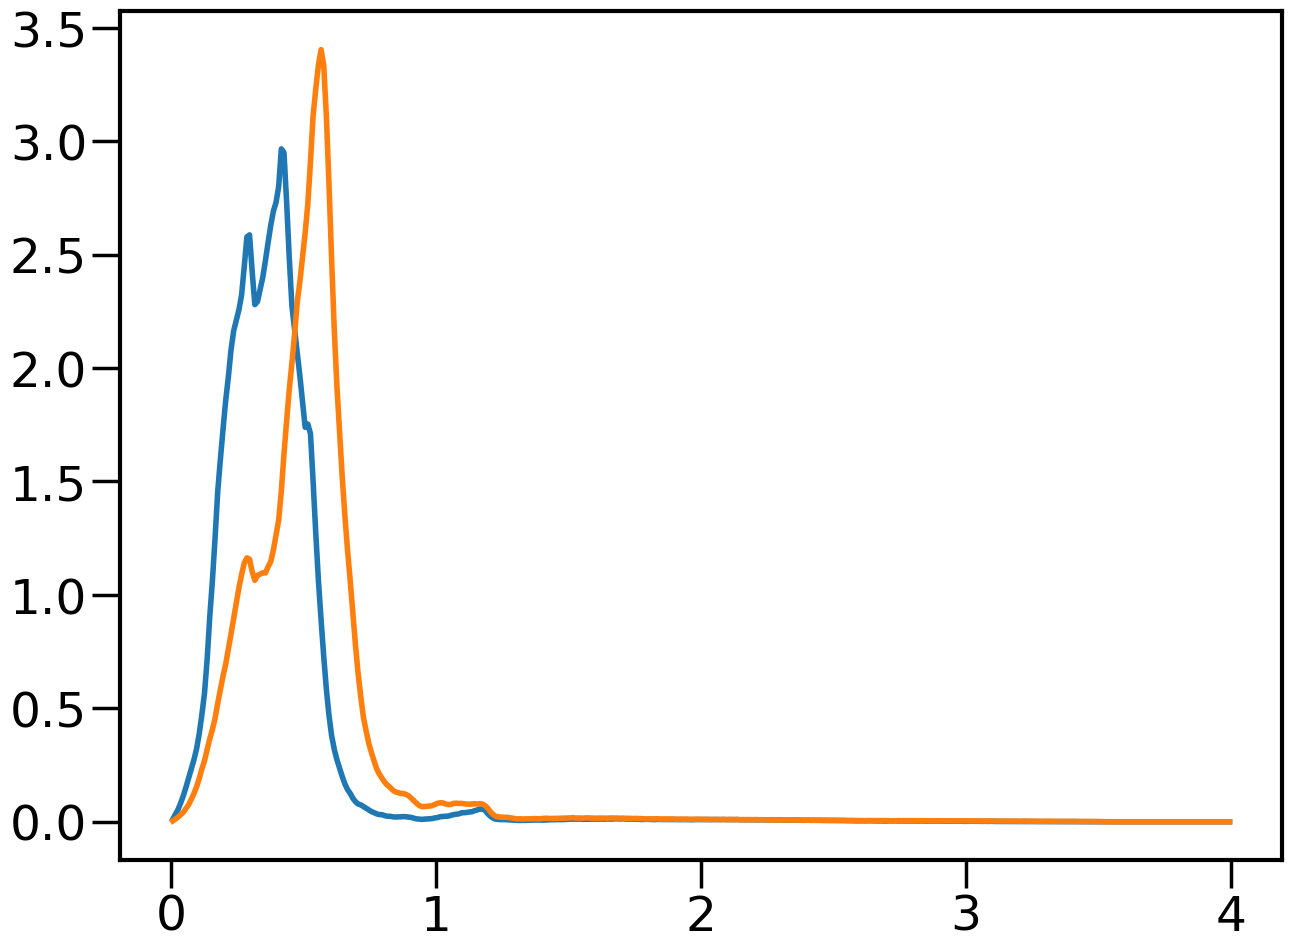

In [14]:
t=DES_dat[6].data
plot(t['Z_MID'],t['BIN1'])
plot(t['Z_MID'],t['BIN2'])

In [15]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins*40)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [16]:
#Hankel Transform setup
l_max=1e4
l_min=2
l0=np.arange(l_min,l_max)
prune_theta=1
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 's1_s2':[(2,2),(2,-2)]}
%time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

cross covariance not implemented with Hankel Transform. s1_s2s: %s [(2, 2), (2, -2)]
pruning theta, log_space:%s n_f:%s True 1
changed l_max to cover theta_min. j_nu= 11594.133199922566 4
pruning theta, log_space:%s n_f:%s True 1
CPU times: user 5.31 s, sys: 0 ns, total: 5.31 s
Wall time: 5.31 s


In [17]:
l0.shape

(9998,)

In [18]:
#Setup redshift bins
zmin=0
zmax=3

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=fname,l=l0,use_window=False)

ns0=np.sum(zs_bins['nz'])

In [19]:
bin_xi=True
l_bins=None


In [20]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=False
sigma_gamma=0.39/np.sqrt(2)

In [21]:
use_window=False

In [23]:
#use redshift bins from power spectrum part
XI_H =Skylens(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,do_sample_variance=do_sample_variance,use_window=use_window,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,WT=HT,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:74: RuntimeWarning: invalid value encountered in true_divide


Win gen: step size 129 True False 9998 31.0
Window done. Size: 1.6e-05


In [24]:
l_bins=np.logspace(1,3,40)

In [25]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': np.arange(2,l_max,dtype='int'),'theta': th*d2r,'s1_s2':[(2,2),(2,-2)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= Skylens(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,do_sample_variance=do_sample_variance,use_window=use_window,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,WT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

Wigner ell max too low for theta_min. Recommendation based on first few zeros of bessel  (2, 2)  : [ 3306.87251811  7590.65227925 11899.73007514 16214.52377613
 20531.48565488]


/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/wigner_transform.py:51: RuntimeWarning: divide by zero encountered in true_divide
  taper_f=np.cos((self.l[None,:]-l_max_low[:,None])/(l_max_high[:,None]-l_max_low[:,None])*np.pi/2.)
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/wigner_transform.py:51: RuntimeWarning: invalid value encountered in true_divide
  taper_f=np.cos((self.l[None,:]-l_max_low[:,None])/(l_max_high[:,None]-l_max_low[:,None])*np.pi/2.)
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/wigner_transform.py:51: RuntimeWarning: invalid value encountered in cos
  taper_f=np.cos((self.l[None,:]-l_max_low[:,None])/(l_max_high[:,None]-l_max_low[:,None])*np.pi/2.)


Wigner ell max too low for theta_min. Recommendation based on first few zeros of bessel  (2, -2)  : [10434.71987993 15215.06772551 19763.65661234 24223.69216079
 28639.08860726]
CPU times: user 977 ms, sys: 2.37 s, total: 3.35 s
Wall time: 23.8 s
Win gen: step size 129 True False 9998 31.0
Window done. Size: 1.6e-05


In [26]:
corr=('shear','shear')

In [27]:
%time xiHG=XI_H.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

In [28]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/binning.py:58: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/binning.py:66: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
%time xiW_L=xiWG_L['stack'].compute()

In [ ]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

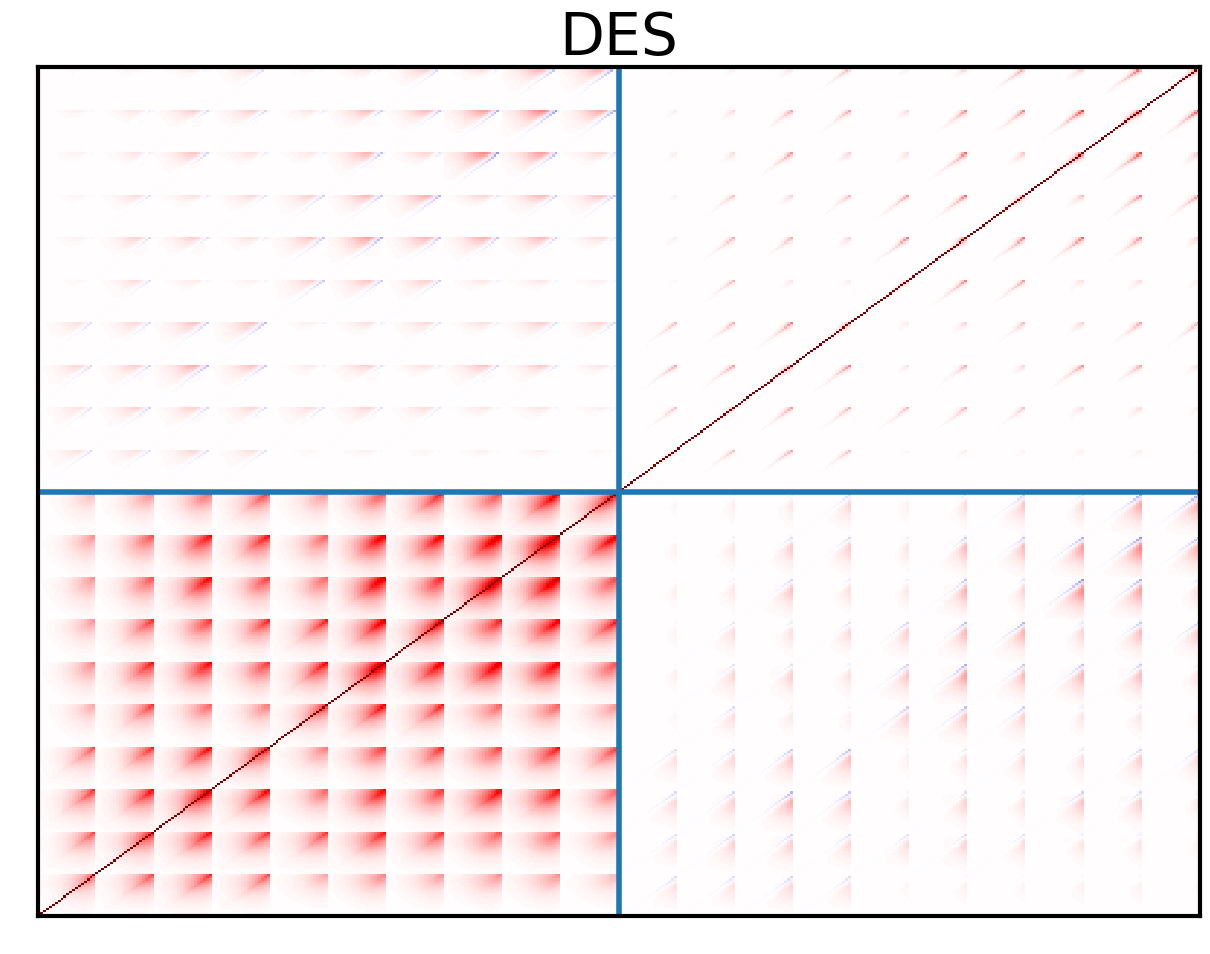

In [22]:
corr_des=cc.corr_matrix(cov_des)
pcolor(corr_des,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('DES')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [ ]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [ ]:
zs_bins[1]['pzdz'].sum(),zs_bins[1]['Norm']

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
#         plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
#         plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
#         xi_plus = ccl.correlation(ccl_cosmo, ell, cls, th,corr_type='L+', method='FFTLog')
#         plot(XI_W_L.l,cls)
        plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
#         hlines(1,2,1000)
        legend()
#         ylim(0.9,1.1)
    show()

In [ ]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb*60,thb*60*xiHG['xi'][corr][m1m2][(i,j)].compute(),
                 thb*60*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j),color=cp[j])
        x=DES_dat[2].data['BIN1']==i+1
        x*=DES_dat[2].data['BIN2']==j+1
        th_t=DES_dat[2].data['ANG'][x]
        plot(th_t,th_t*DES_dat[2].data['VALUE'][x],color=cp[j])
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [ ]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        plot(thb/d2r,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j),
            c=cs[(i2+j2)%len(cs)])
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.sqrt(np.diag(cov_des[indx0:indx0+nth,indx0:indx0+nth])),c=cs[(i2+j2)%len(cs)],ls='--')
        j2+=1
    i2+=1
xscale('log')
yscale('log')
xlabel(r'$\theta$ (arc min)')
ylabel(r'$\xi_+$')
legend(ncol=3)

In [ ]:
th,Win2=XI_W_L.HT.projected_correlation(l_cl=XI_W_L.l,m1_m2=(2,2),cl=XI_W_L.cov_utils.Win)

In [ ]:
plot(th/d2r,Win2)
xscale('log')

In [ ]:
plot(XI_W_L.l,XI_W_L.cov_utils.Win)
xscale('log')
yscale('log')

In [ ]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])*2/np.diag(cov_des[indx0:indx0+nth,indx0:indx0+nth]),
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [ ]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [ ]:
crash

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)